In [1]:
import pandas as pd

# Load dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


/tmp/ipykernel_5436/136049981.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


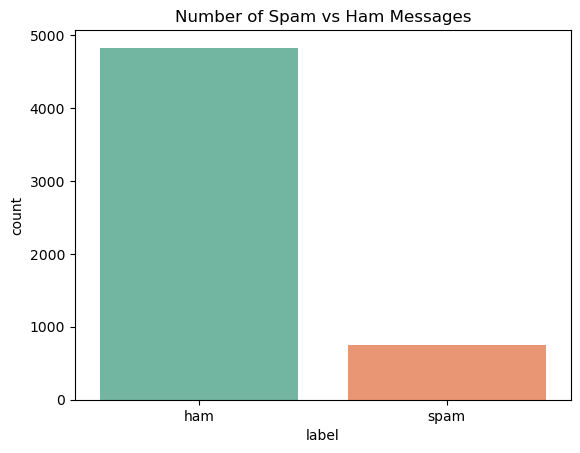

In [6]:
# Count plot
sns.countplot(data=df, x='label', palette='Set2')
plt.title("Number of Spam vs Ham Messages")
plt.show()


In [7]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)


In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


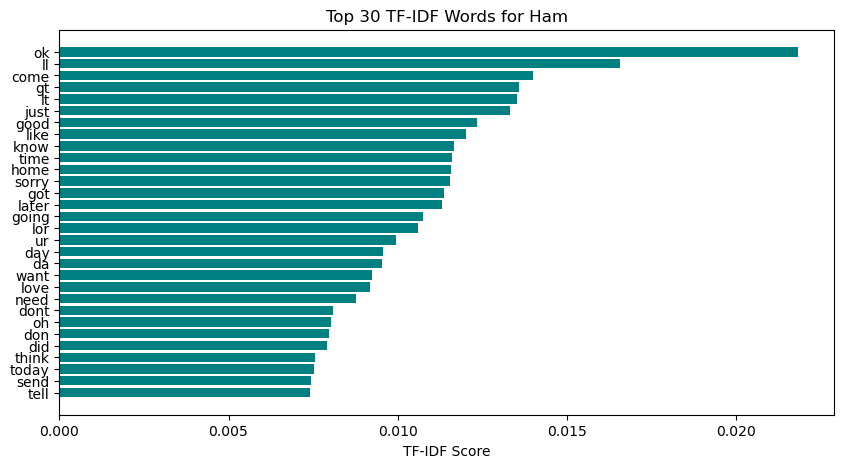

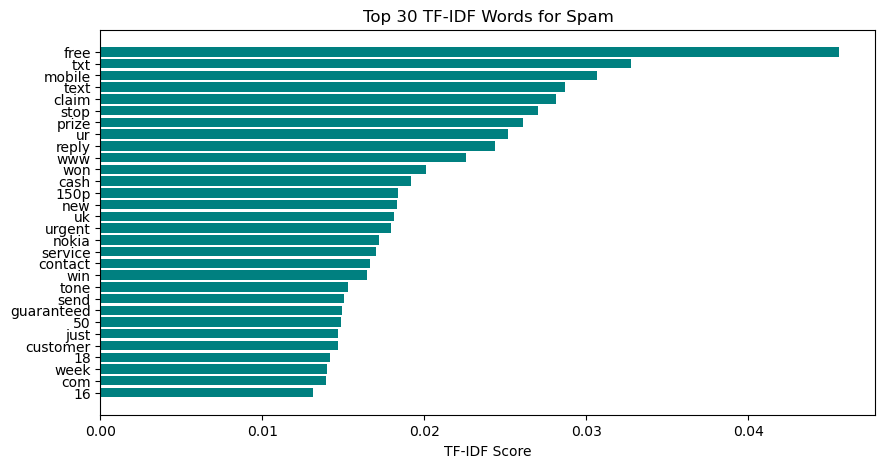

In [13]:
def plot_top_words(vectorizer, class_label, top_n=20):
    tfidf = vectorizer.transform(df[df['label'] == class_label]['message'])
    mean_tfidf = tfidf.mean(axis=0).A1
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    sorted_idx = np.argsort(mean_tfidf)[-top_n:]
    plt.figure(figsize=(10,5))
    plt.barh(feature_names[sorted_idx], mean_tfidf[sorted_idx], color='teal')
    label_name = "Ham" if class_label == 0 else "Spam"
    plt.title(f"Top {top_n} TF-IDF Words for {label_name}")
    plt.xlabel("TF-IDF Score")
    plt.show()

plot_top_words(vectorizer, class_label=0,top_n=30)  # Ham
plot_top_words(vectorizer, class_label=1,top_n=30)  # Spam


In [15]:
log_clf = LogisticRegression()
log_clf.fit(X_train_vec,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [16]:
y_pred_log = log_clf.predict(X_test_vec)

In [17]:
y_pred_log

array([0, 0, 0, ..., 0, 0, 0], shape=(1115,))

In [18]:
log_clf.predict(X_test_vec[2])

array([0])

In [19]:
print(X_test[2])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [20]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_vec, y_train)
y_pred_sgd = sgd_clf.predict(X_test_vec)


In [21]:
def evaluate(y_true, y_pred, model_name="Model"):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate(y_test, y_pred_log, "Logistic Regression")
evaluate(y_test, y_pred_sgd, "SGD Classifier")

if 'y_pred_df' in locals():
    evaluate(y_test, y_pred_df, "Deep Forest")


--- Logistic Regression ---
Accuracy: 0.967713004484305
Confusion Matrix:
 [[966   0]
 [ 36 113]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

--- SGD Classifier ---
Accuracy: 0.9820627802690582
Confusion Matrix:
 [[962   4]
 [ 16 133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [22]:
import joblib
joblib.dump(log_clf, "spam_logistic_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# To load later
# model = joblib.load("spam_logistic_model.pkl")
# vect = joblib.load("tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [23]:
model = joblib.load("spam_logistic_model.pkl")
vect = joblib.load("tfidf_vectorizer.pkl")

In [28]:
# Local custom messages
messages = [
    "Congratulations! You've won a $500 Walmart gift card. Click here to claim.",
    "Hey bro, are you free to play tonight?",
    "Your Netflix account has been suspended. Log in to verify your details.",
    "Don't forget to submit your assignment by 6 PM.",
    "Hey fuck you",
    "Do you want a choclate click this link",
    "Get free choclate here"
]


In [29]:
# Vectorize input messages
X_local = vectorizer.transform(messages)

# Predict
predictions = model.predict(X_local)

# Decode and print result
for msg, pred in zip(messages, predictions):
    label = "Spam" if pred == 1 else "Ham"
    print(f"> {msg} \n→ Prediction: {label}\n")


> Congratulations! You've won a $500 Walmart gift card. Click here to claim. 
→ Prediction: Spam

> Hey bro, are you free to play tonight? 
→ Prediction: Ham

> Your Netflix account has been suspended. Log in to verify your details. 
→ Prediction: Ham

> Don't forget to submit your assignment by 6 PM. 
→ Prediction: Ham

> Hey fuck you 
→ Prediction: Ham

> Do you want a choclate click this link 
→ Prediction: Ham

> Get free choclate here 
→ Prediction: Spam

